# Graph Mining

In [1]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import csv
import numpy as np

#pip install community
#pip install python-louvain
import community as community_louvain
from community.community_louvain import modularity

## 1. Data loading

### 1.1 household members

In [2]:
houses = {}
with open("scc2034_kilifi_all_contacts_within_households.csv", 'r') as csvfile:
    plots = csv.reader(csvfile, delimiter=",", skipinitialspace=True)
    next(plots, None)
    for row in plots:
        houses.setdefault(row[0], set())
        houses[row[0]].add(row[1])
        houses[row[0]].add(row[3])
        
print(f"The {len(houses['E'])} members of household E : {houses['E']}")
print(f"The {len(houses['F'])} members of household F : {houses['F']}")
print(f"The {len(houses['L'])} members of household L : {houses['L']}")
print(f"The {len(houses['H'])} members of household H : {houses['H']}")
print(f"The {len(houses['B'])} members of household B : {houses['B']}")

The 17 members of household E : {'20', '17', '6', '5', '10', '22', '2', '13', '11', '27', '25', '9', '30', '23', '16', '15', '4'}
The 8 members of household F : {'5', '9', '7', '1', '11', '12', '3', '10'}
The 6 members of household L : {'6', '8', '7', '1', '3', '4'}
The 29 members of household H : {'46', '28', '51', '32', '18', '41', '8', '14', '40', '50', '47', '15', '10', '39', '6', '36', '26', '49', '29', '33', '43', '45', '30', '44', '34', '7', '3', '4', '19'}
The 15 members of household B : {'32', '5', '36', '38', '56', '8', '26', '58', '27', '25', '12', '50', '47', '42', '4'}


### 1.2 Create graph

In [3]:
def get_graph(csv_path):
    G = nx.Graph()
    with open(csv_path,'r') as csvfile:
        plots = csv.reader(csvfile, delimiter = ',', skipinitialspace=True)
        next(plots, None)  # on passe la première ligne (le header)
        for row in plots:
            G.add_node(row[1])
            G.add_node(row[3])
            if G.has_edge(row[1],row[3]):
                G[row[1]][row[3]]['weight'] += int(row[8])
            else:
                G.add_edge(row[1], row[3],weight=int(row[8]))
    return G

In [4]:
G_within = get_graph("scc2034_kilifi_all_contacts_within_households.csv")
G_across = get_graph("scc2034_kilifi_all_contacts_across_households.csv")

## 2. Basic properties

### 2.1 Degree distribution

In [5]:
def plot_degree_distribution_kenya(G, dataset_name=None):  
    n_nodes = G.number_of_nodes()
    degs = np.zeros(n_nodes, dtype=int)
    for node in G.nodes():
        # ressort le noeud (l'individu) et le nombres de connexions qui sortent
        # ou qui entrent... 
        # print (node, G.degree(node))
        deg = G.degree(node)
        degs[deg] += 1
    
    #get p(k) distribution
    degree_distribution = np.zeros(n_nodes, dtype=float)
    degree_distribution = list(map(lambda d : float(d)/n_nodes, degs)) 
    avg_degree = sum([k*pk for (k, pk) in enumerate(degree_distribution)])
    print(f'average degree : {avg_degree}')

    #ressort le nombres de connexions et combiens de fois ce nombres
    # de connexion a été trouvé parmi les individus...
    # print(items)
    fig2 = plt.figure()
    ax=fig2.add_subplot(111)
    ax.bar(range(n_nodes), degree_distribution, width=1.0, edgecolor='black')
    plt.xlabel("Degree")
    plt.ylabel("Fraction of nodes")
    plt.title(f"Social contacts in households: Degree Distribution (Kenya){' - ' if dataset_name else ''}{dataset_name}")

average degree : 20.382978723404253


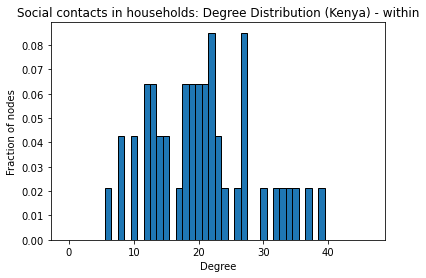

In [6]:
plot_degree_distribution_kenya(G_within, dataset_name="within")

average degree : 5.142857142857142


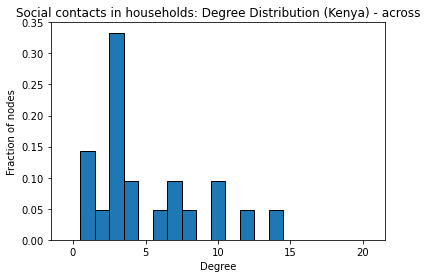

In [7]:
plot_degree_distribution_kenya(G_across, dataset_name="across")

### 2.2 Centralities

In [8]:
#https://aksakalli.github.io/2017/07/17/network-centrality-measures-and-their-visualization.html
def draw(G, pos, measures, measure_name):
    plt.figure(figsize=(20,20))
    nodes = nx.draw_networkx_nodes(G, pos, node_size=900, cmap=plt.cm.hot, node_color=list(map(lambda x : 1 - x,measures.values())), nodelist=measures.keys())
    
    #get threshold to color label in white
    sm = sorted(measures.values())
    s = 0
    threshold = 0
    i = 0
    while(i < len(sm) and s < sum(sm) *  0.8):
        threshold = sm[i]
        s += threshold
        i += 1
        
    #get label colors
    l = {}
    lp = {}
    pos_1 = {}
    pos_2 = {}
    for node in G.nodes():
        if measures[node] >= threshold :
            lp[node] = node
            pos_1[node] = pos[node]
        else:
            l[node] = node
            pos_2[node] = pos[node]     
    
    labels_1 = nx.draw_networkx_labels(G, pos_2, l, font_size=18)
    labels_2 = nx.draw_networkx_labels(G, pos_1, lp, font_size=18, font_color="white")
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    edges = nx.draw_networkx_edges(G, pos)
    
    plt.title(measure_name, fontsize=24)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

In [9]:
C_TYPE = {
    0 : "Degree centrality",
    1 : "Eigenvector centrality",
    2 : "Closeness centrality",
    3 : "Betweenness centrality"
}

In [10]:
from networkx.algorithms.centrality.degree_alg import degree_centrality

def centrality_visu(G, c_type_index, dataset_name):
    centrality_function = [nx.degree_centrality, nx.eigenvector_centrality, nx.closeness_centrality, nx.betweenness_centrality]
    G_nodes = G.number_of_nodes()
    G_edges = G.number_of_edges()
    print("Nodes = ", G_nodes, " Edges = ",G_edges)
    #permet d'afficher les noeuds et liens du Graphe G
    print(nx.info(G)) 
    pos = nx.spring_layout(G, seed=600)
    draw(G, pos, centrality_function[c_type_index](G), f'{C_TYPE[c_type_index]} - {dataset_name}')

#### 2.2.1 Degree centrality

Nodes =  47  Edges =  479
Name: 
Type: Graph
Number of nodes: 47
Number of edges: 479
Average degree:  20.3830


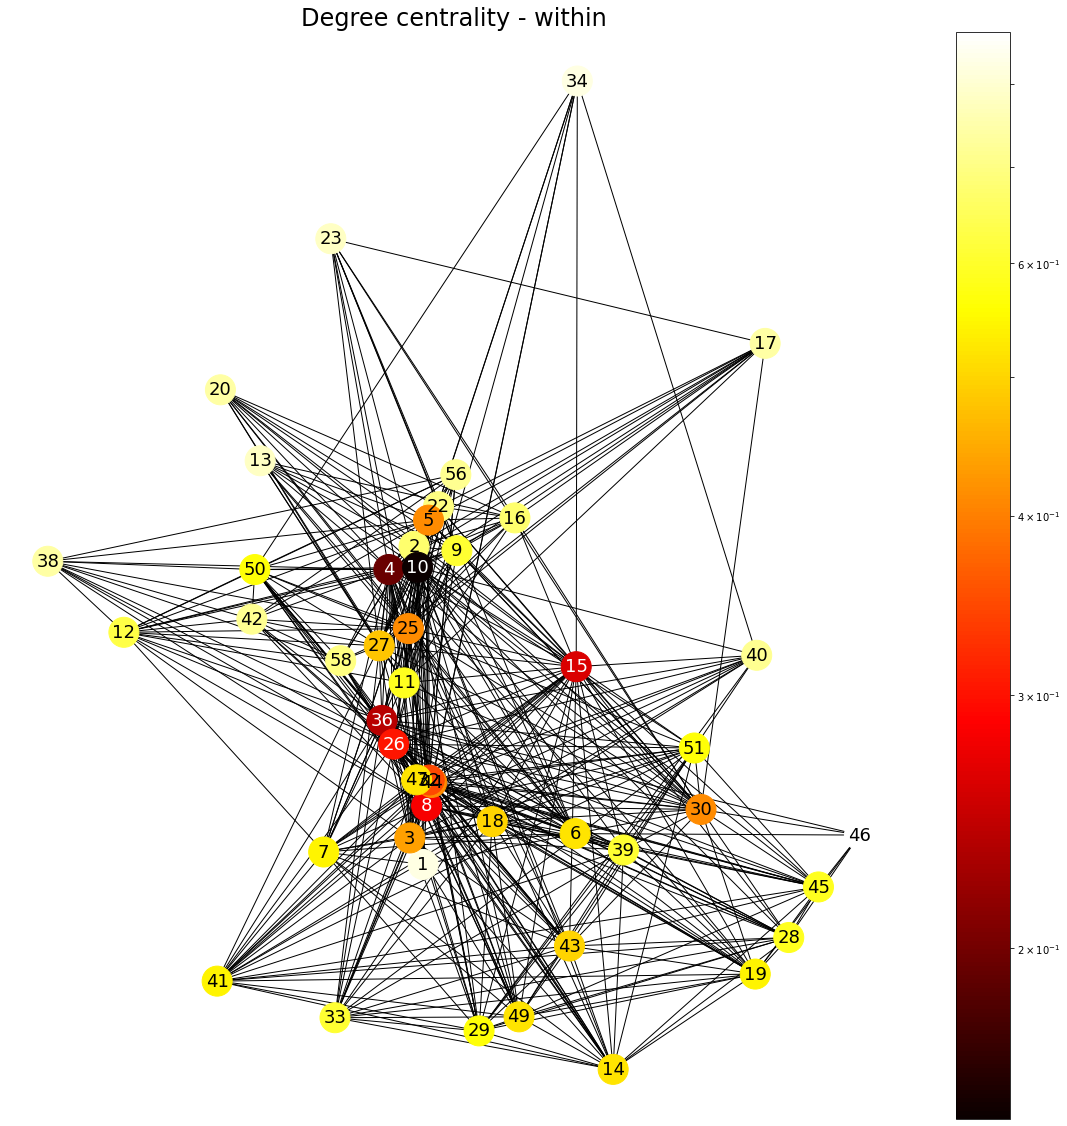

In [11]:
centrality_visu(G_within, 0, "within")

Nodes =  21  Edges =  54
Name: 
Type: Graph
Number of nodes: 21
Number of edges: 54
Average degree:   5.1429


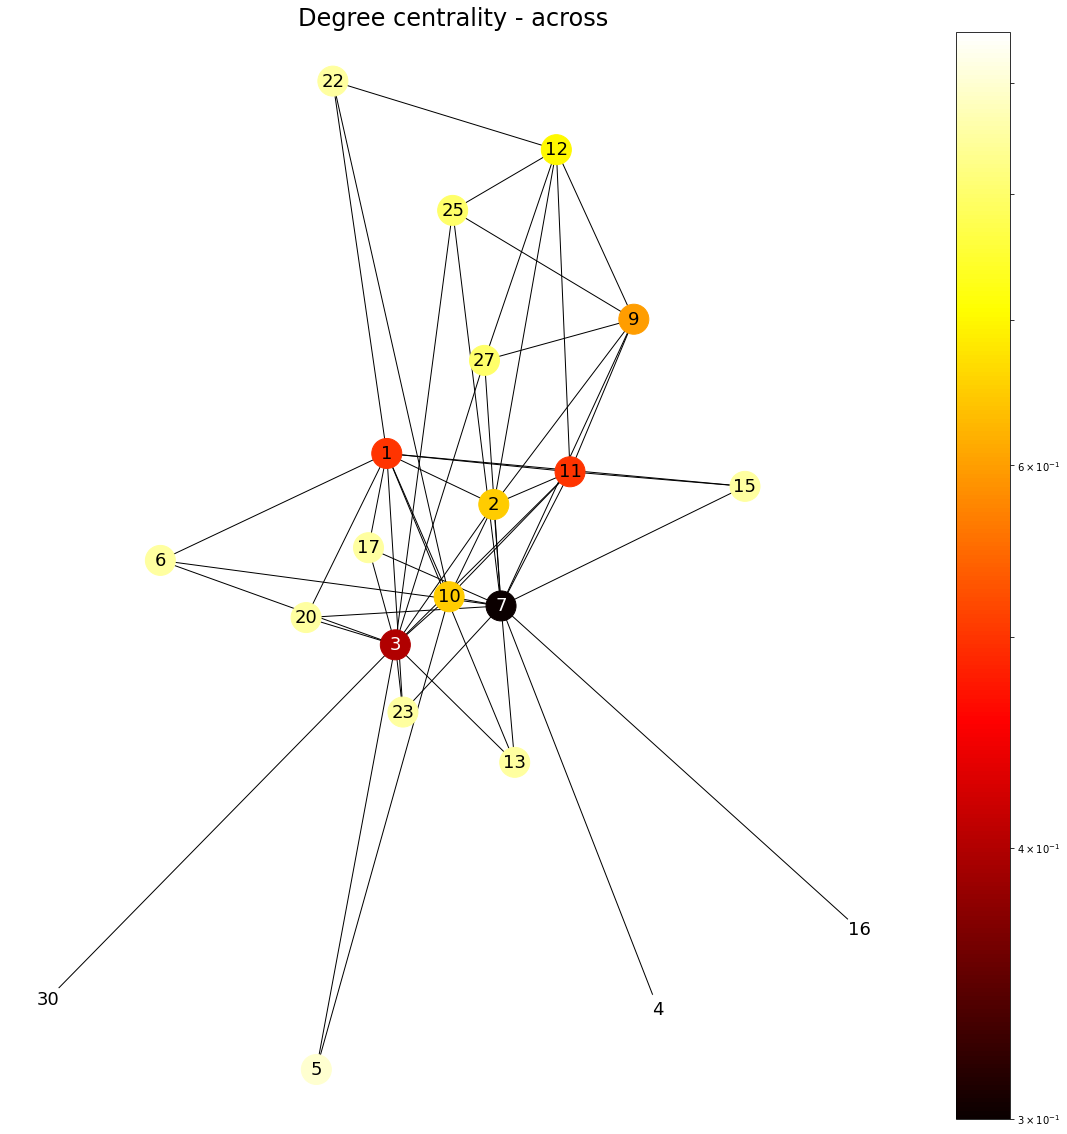

In [12]:
centrality_visu(G_across, 0, "across")

#### 2.2.2 Eigenvector centrality

Nodes =  47  Edges =  479
Name: 
Type: Graph
Number of nodes: 47
Number of edges: 479
Average degree:  20.3830


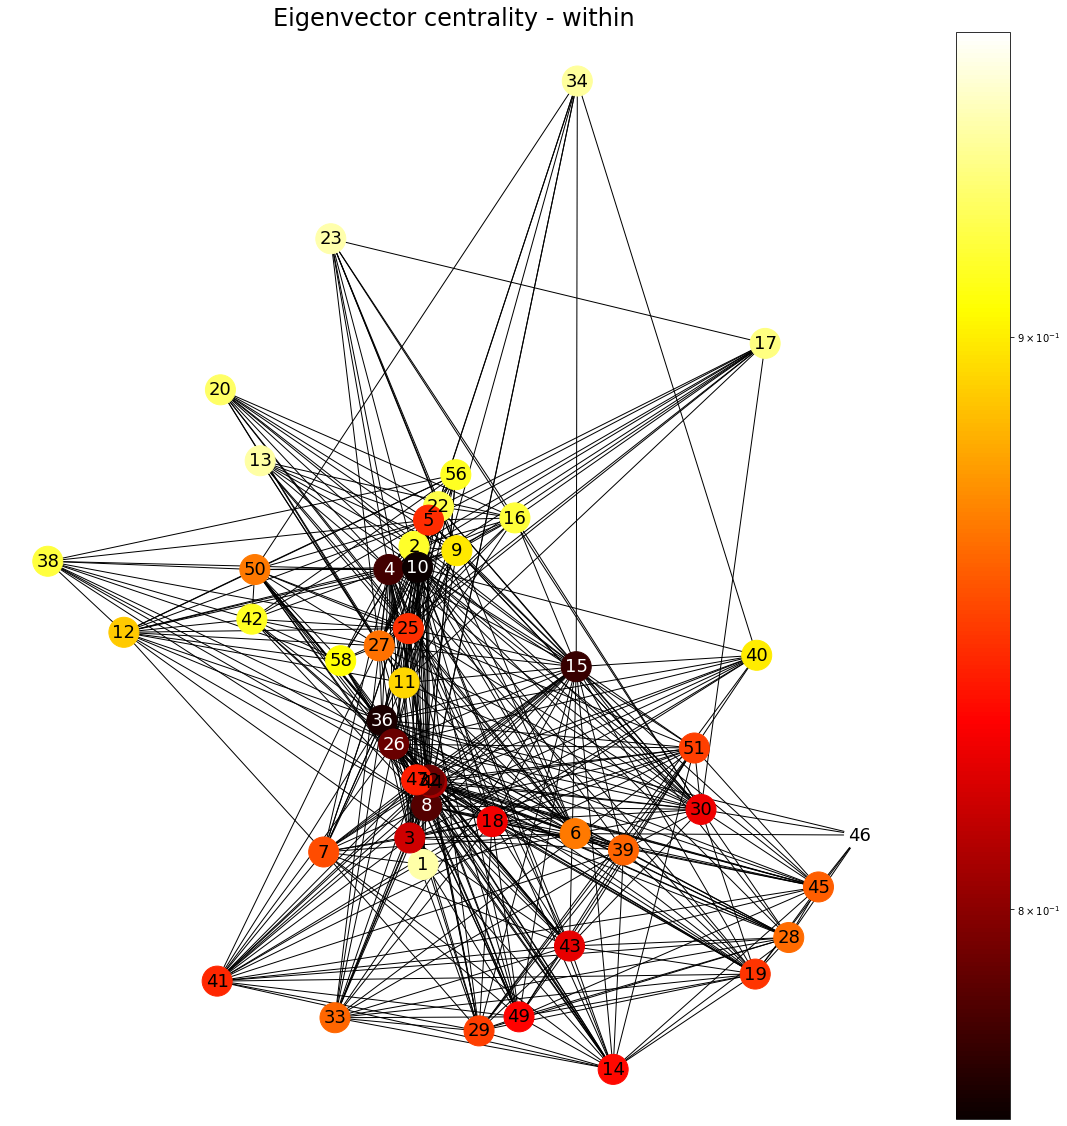

In [13]:
centrality_visu(G_within, 1, "within")

Nodes =  21  Edges =  54
Name: 
Type: Graph
Number of nodes: 21
Number of edges: 54
Average degree:   5.1429


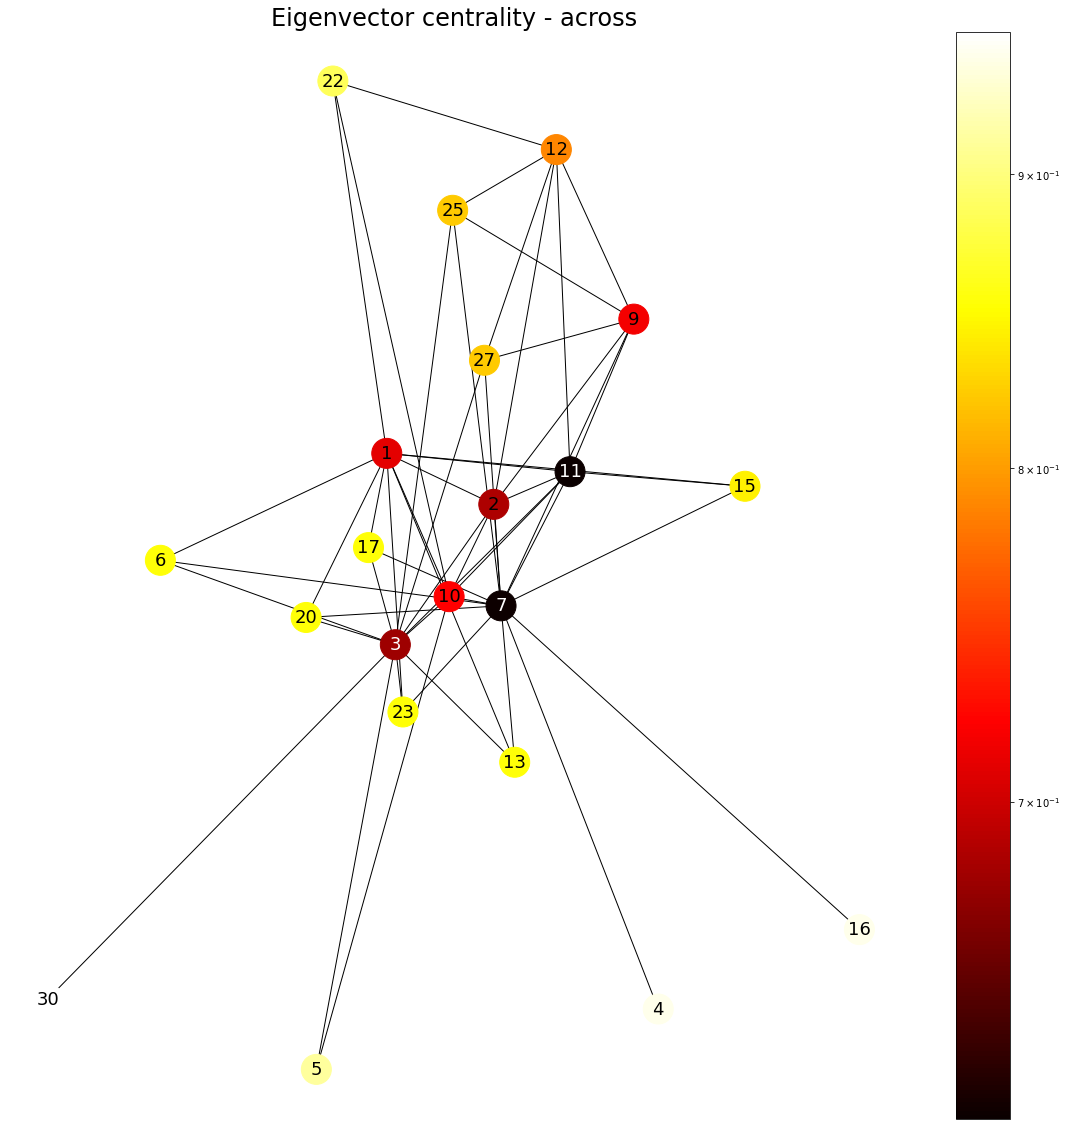

In [14]:
centrality_visu(G_across, 1, "across")

#### 2.2.3 Closeness centrality

Nodes =  47  Edges =  479
Name: 
Type: Graph
Number of nodes: 47
Number of edges: 479
Average degree:  20.3830


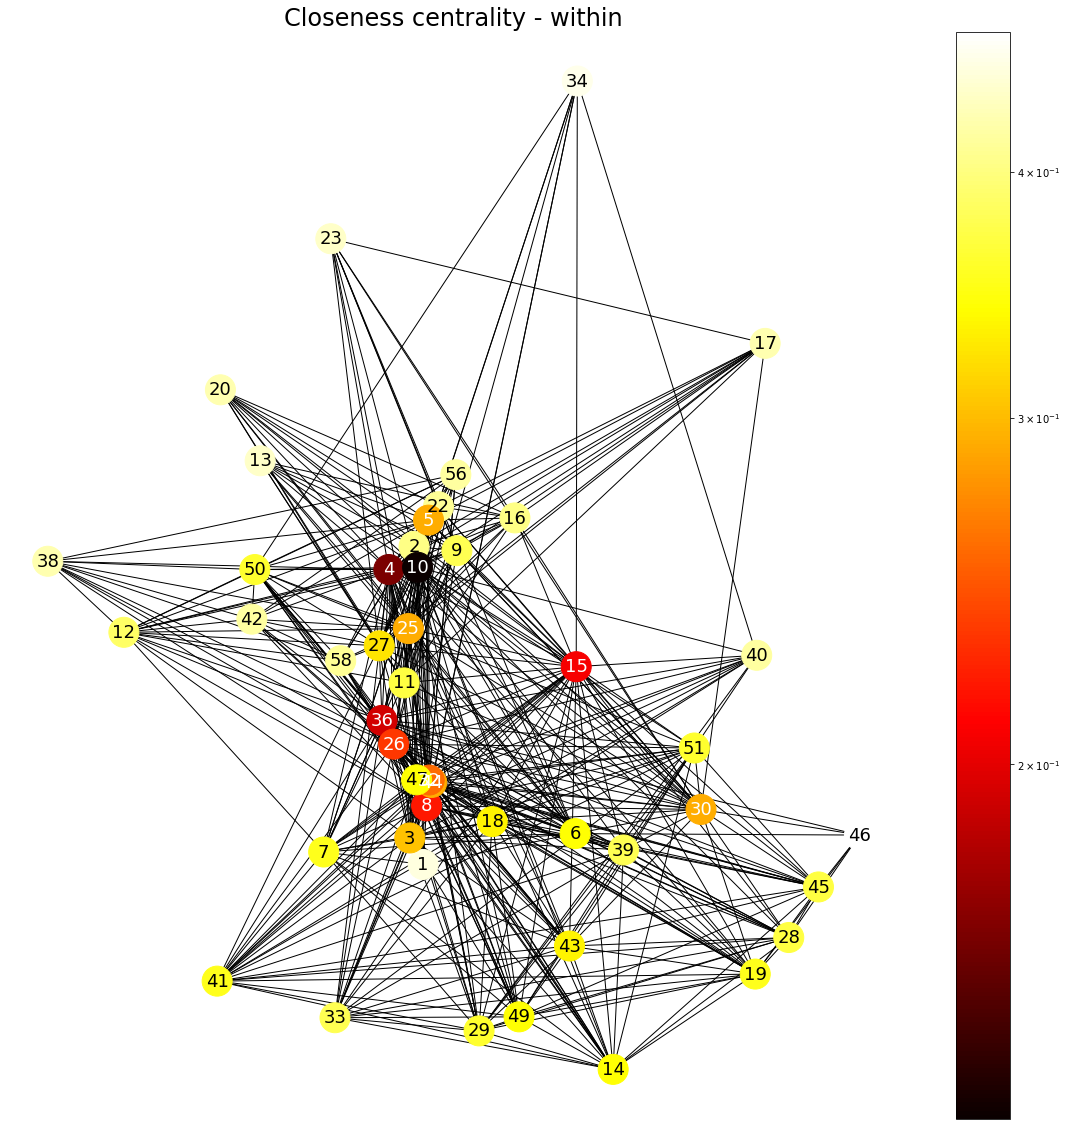

In [15]:
centrality_visu(G_within, 2, "within")

Nodes =  21  Edges =  54
Name: 
Type: Graph
Number of nodes: 21
Number of edges: 54
Average degree:   5.1429


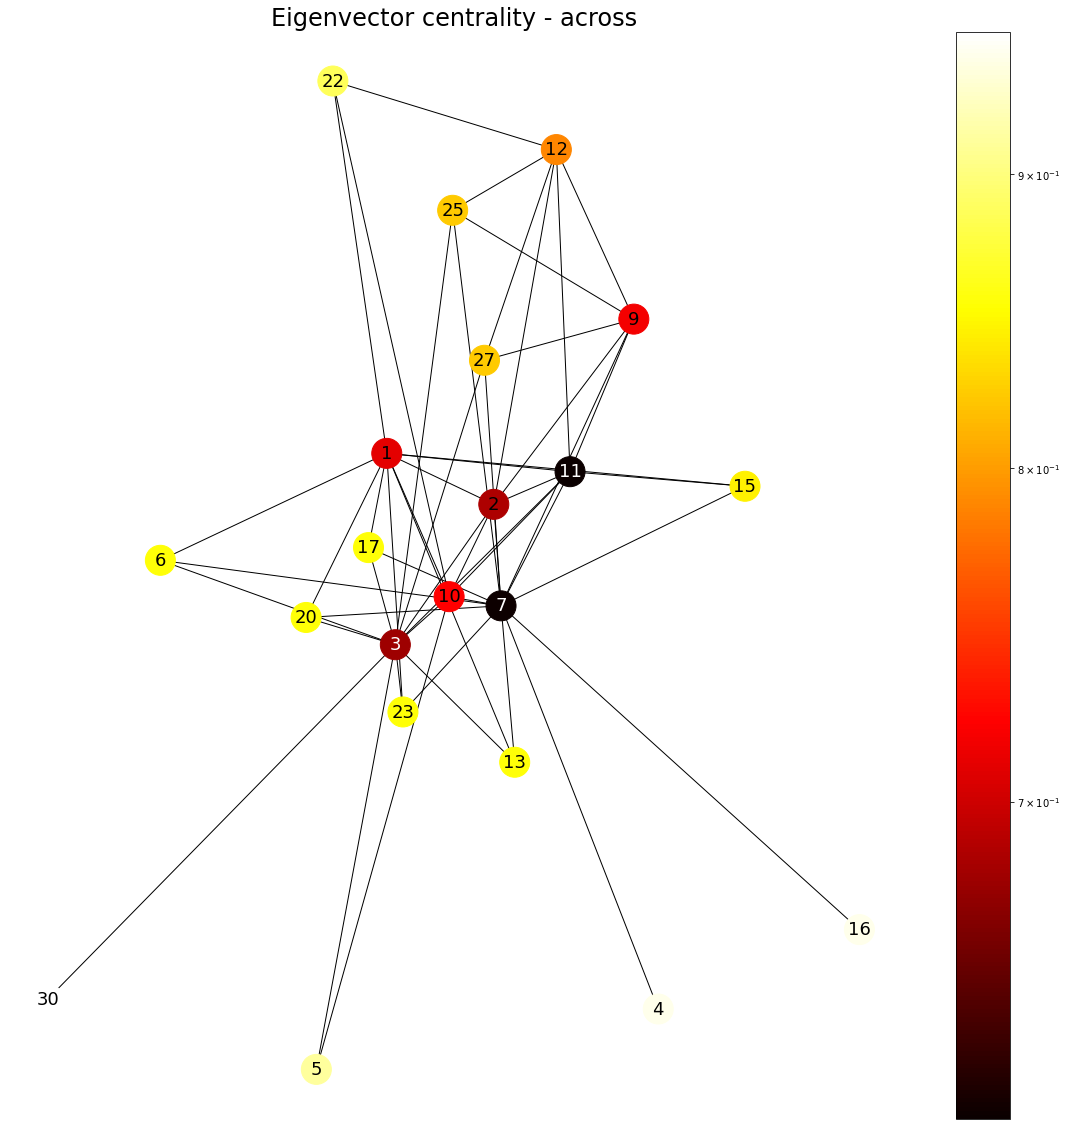

In [16]:
centrality_visu(G_across, 1, "across")

#### 2.2.4 Betweenness centrality

Nodes =  47  Edges =  479
Name: 
Type: Graph
Number of nodes: 47
Number of edges: 479
Average degree:  20.3830


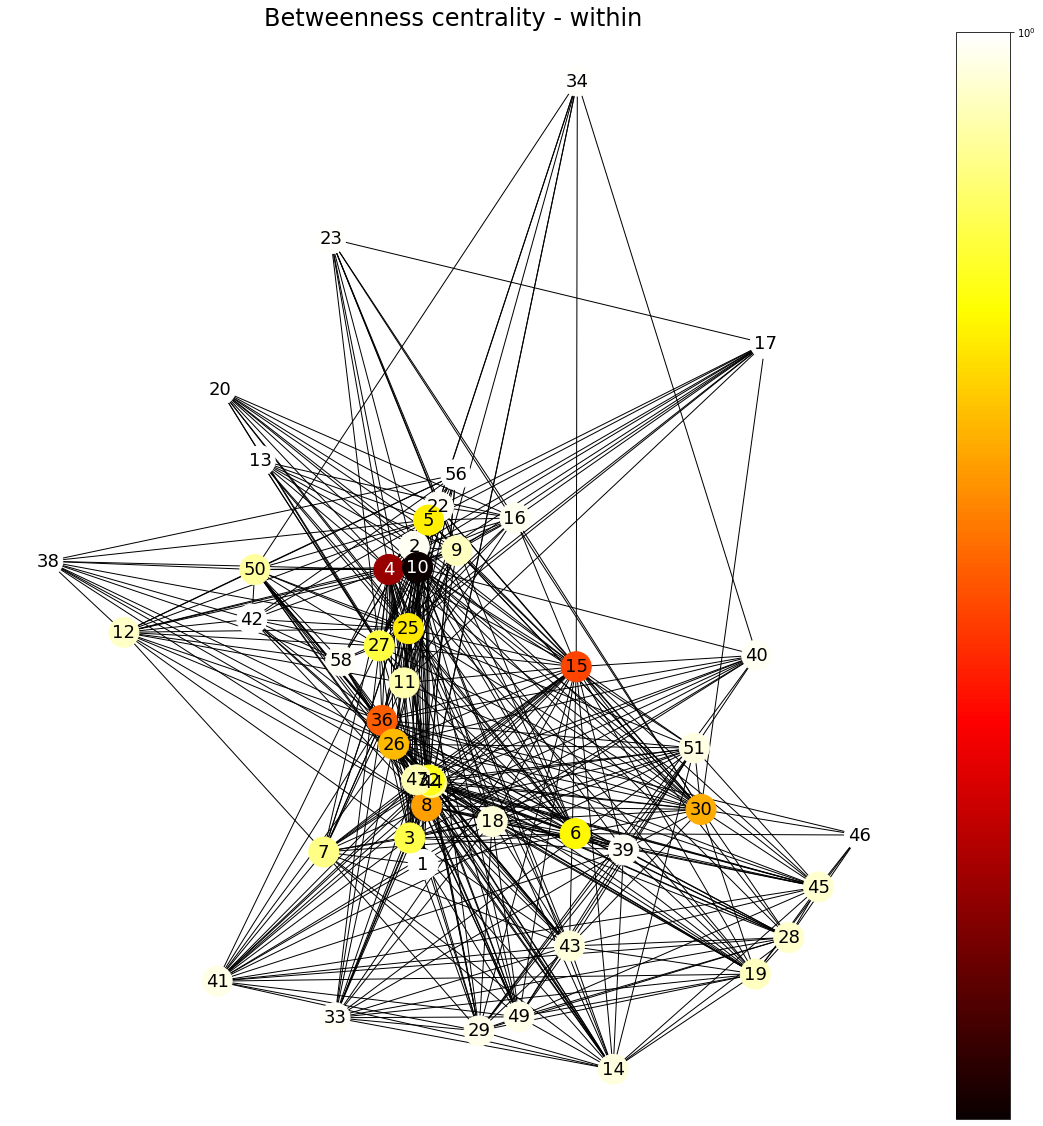

In [17]:
centrality_visu(G_within, 3, "within")

Nodes =  21  Edges =  54
Name: 
Type: Graph
Number of nodes: 21
Number of edges: 54
Average degree:   5.1429


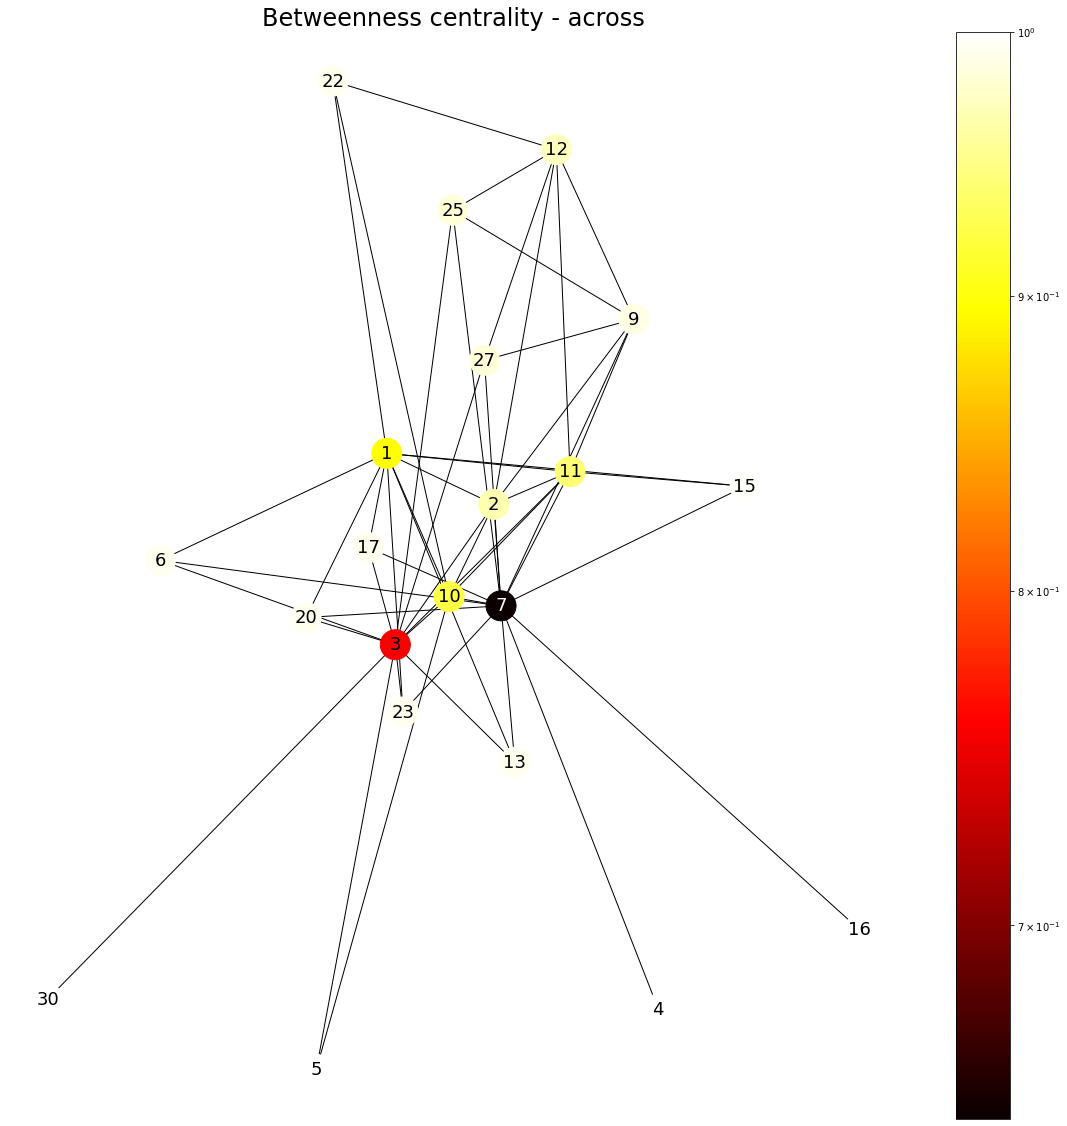

In [18]:
centrality_visu(G_across, 3, "across")

### 2.3 Clustering coefficient

In [19]:
def clustering_coefficient_visu(G, dataset_name):
    G_nodes = G.number_of_nodes()
    G_edges = G.number_of_edges()
    print("Nodes = ", G_nodes, " Edges = ",G_edges)
    pos = nx.spring_layout(G, seed=600)
    #Affichage du coefficient de clustering du graphe (coeficient de 0 à 1)
    # le coefficient de regroupement local
    coefficient_de_regroupement_local = nx.clustering(G)
    draw(G, pos, coefficient_de_regroupement_local, f"local clustering coefficient - {dataset_name}")

    # le coefficient de regroupement moyen
    coef_moy = nx.average_clustering(G)
    print(f"coefficient de regroupement moyen pour le dataset '{dataset_name}' : {coef_moy}")

Nodes =  47  Edges =  479


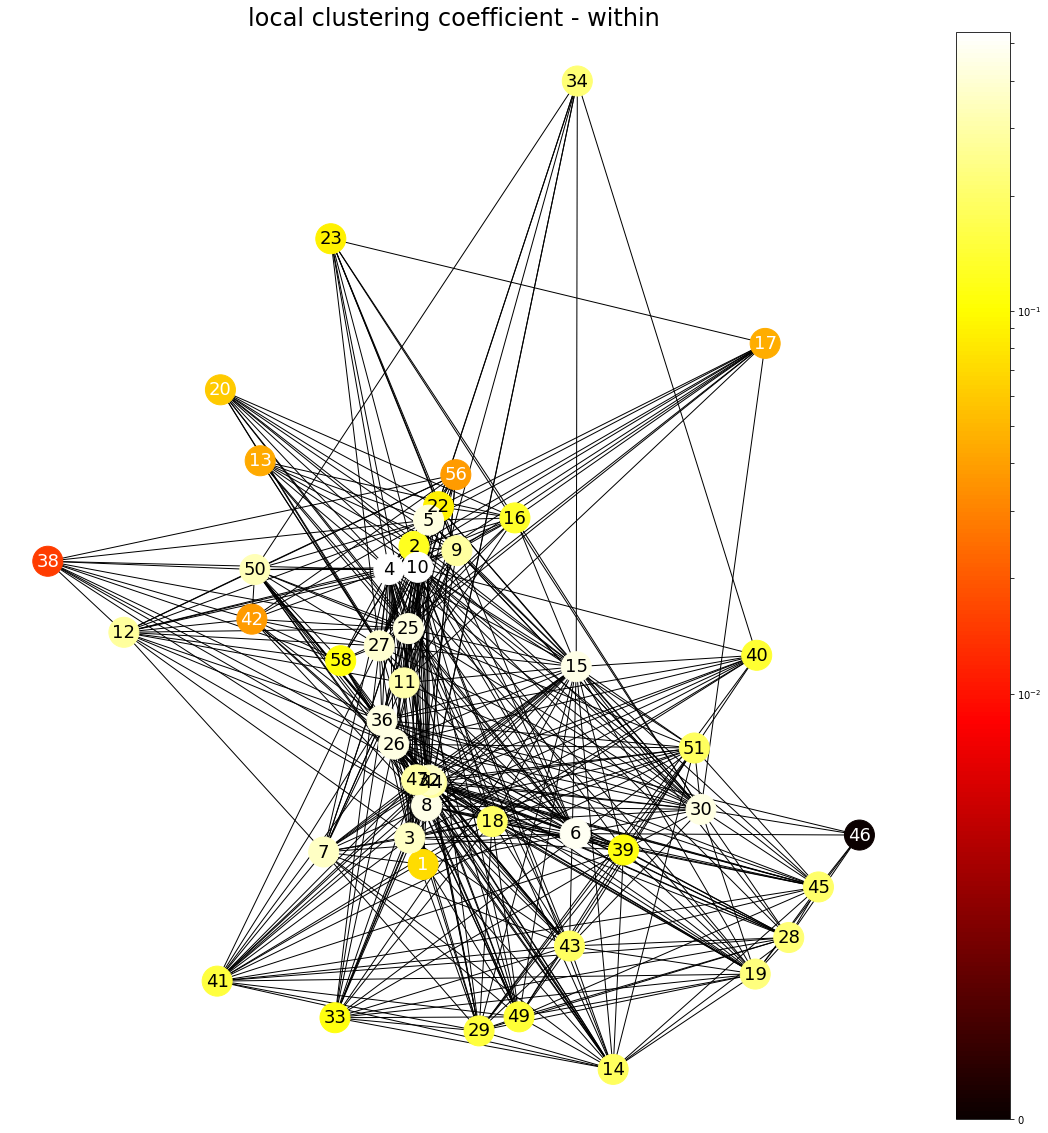

coefficient de regroupement moyen pour le dataset 'within' : 0.7611579074315542


In [20]:
clustering_coefficient_visu(G_within, "within")

Nodes =  21  Edges =  54


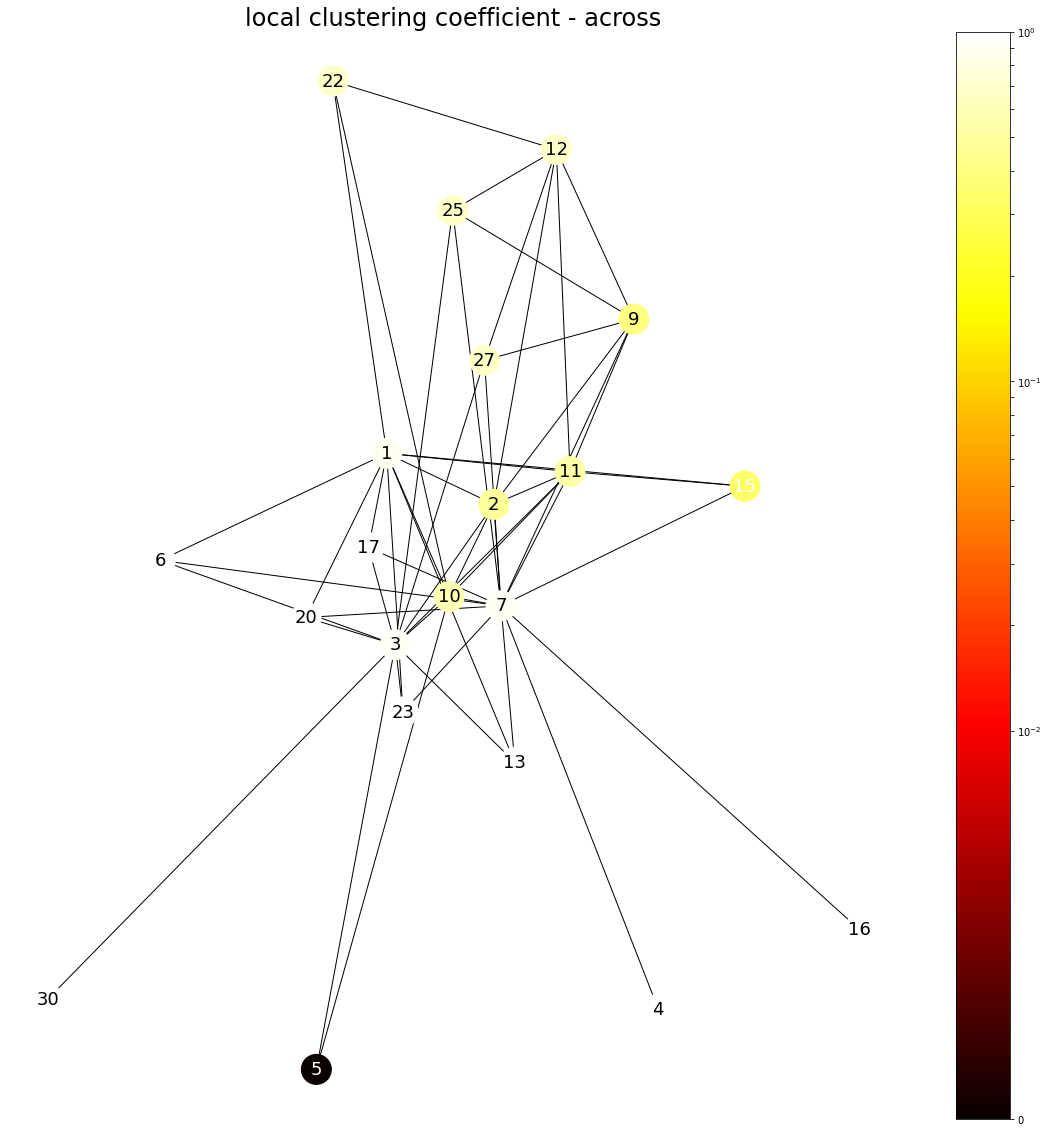

coefficient de regroupement moyen pour le dataset 'across' : 0.25125218696647267


In [21]:
clustering_coefficient_visu(G_across, "across")

## 3 Community detection

In [22]:
# via fichier csv 
def display_communautes(G, dataset_name):
    G_nodes = G.number_of_nodes()
    G_edges = G.number_of_edges()
    print("Nodes = ", G_nodes, " Edges = ",G_edges)

    # compute the best partition
    partition = community_louvain.best_partition(G)

    # la modularité
    print("Modularité:",modularity(partition,G))
    
    pos = nx.spring_layout(G, seed=600)
    p1 = {k if partition[k] == 0 else '999' : v if partition[k] == 0 else _ for (k,v) in pos.items()}
    del(p1['999'])
    p2 = {k:pos.get(k, p1.get(k)) for k in set(pos) ^ set(p1)}
    
    # color the nodes according to their partition
    plt.figure(figsize=(20,20))
    cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
    nx.draw_networkx_labels(G, p2, {k:k for (k, _) in p2.items()}, font_size=14)
    nx.draw_networkx_labels(G, p1, {k:k for (k, _) in p1.items()}, font_size=14, font_color="white")
    nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=900, cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.title(f"Communities - {dataset_name}", fontsize=24)
    plt.show()

Nodes =  47  Edges =  479
Modularité: 0.4565359452659436


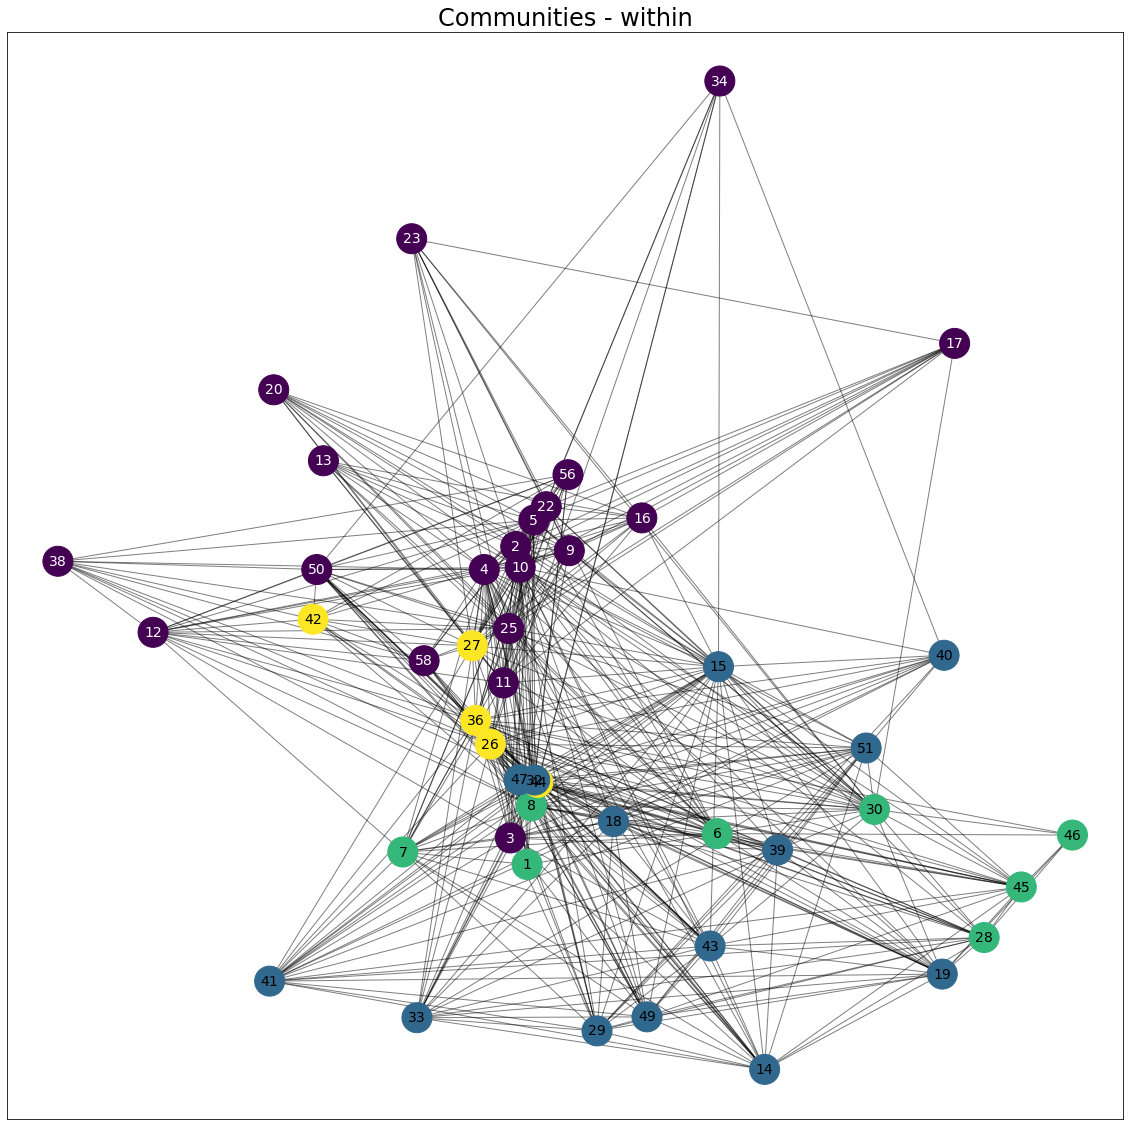

In [23]:
display_communautes(G_within, "within")

Nodes =  21  Edges =  54
Modularité: 0.2907666015625


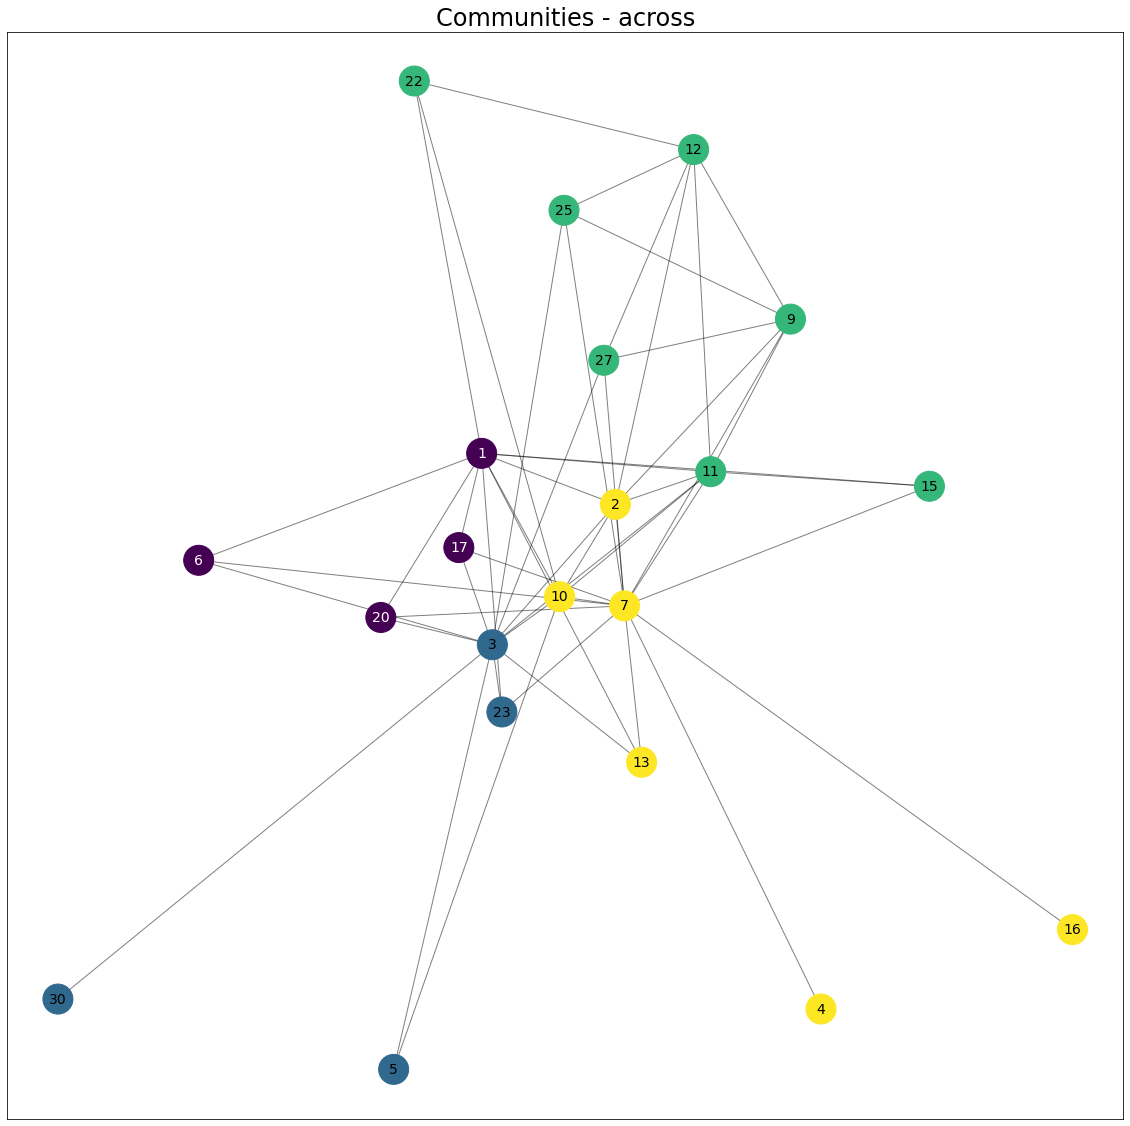

In [24]:
display_communautes(G_across, "across")

## Random Walk

In [37]:
#https://stackoverflow.com/questions/37311651/get-node-list-from-random-walk-in-networkx
# + syllabus page 12 - Markov chain
import random
def random_walk(G, steps=None, start_node=None):
    nodes = list(G.nodes)
    A = nx.adj_matrix(G)
    A = A.todense()
    A = np.array(A, dtype = np.float64)
    D = np.diag(np.sum(A, axis=0))
    T = np.dot(np.linalg.inv(D), A)
    random_node = start_node if start_node else int(np.random.choice(nodes))
    print(f"Start at node : {random_node}")
    visited_nodes = [str(random_node)]
    visited_edges = []
    p = np.array([1 if k == nodes.index(str(random_node)) else 0 for k in range(G.number_of_nodes())]).reshape(-1, 1)
    if steps:
        s = step
        for k in range(steps):
            if len(visited_nodes) % 2 == 0:
                visited_edges.append((visited_nodes[-2], visited_nodes[-1]))
            p = np.dot(T, p)
            indexes = [nodes.index(n) for n in [k for k in G.neighbors(visited_nodes[-1])]]
            temp = []
            for i in indexes:
                temp.append(p[i])
            temp = [float(p/sum(temp)) for p in temp]
            i_visit = np.random.choice(indexes, p=list(temp))
            visited_nodes.append(nodes[i_visit])
    else:
        to_visit = [n for n in G.nodes]
        s = 0
        while to_visit :
            p = np.dot(T, p)
            indexes = [nodes.index(n) for n in [k for k in G.neighbors(visited_nodes[-1])]]
            temp = []
            for i in indexes:
                temp.append(p[i])
            temp = [float(p/sum(temp)) for p in temp]
            i_visit = np.random.choice(indexes, p=list(temp))
            visited_nodes.append(nodes[i_visit])
            if nodes[i_visit] in to_visit:
                to_visit.remove(nodes[i_visit])
            s += 1
    print(f"Steps : {s}")
    return visited_nodes, visited_edges

In [38]:
def random_walk_visu(G, visited_nodes, visited_edges, dataset_name):
    occ_node = {v:visited_nodes.count(v) for v in visited_nodes}
    occ_edges = {v:visited_edges.count(v) for v in visited_edges}
    
    node_sizes = {k:(100*(occ_node[k]/1.5) if k in occ_node.keys() else 100) for k in list(G.nodes)}
    edge_occ = {k:(occ_edges[k] if k in occ_edges.keys() else 1) for k in list(G.edges)}
    
    pos = nx.spring_layout(G, seed=600)
    plt.figure(figsize=(20,20))
    nodes = nx.draw_networkx_nodes(G, pos, node_size=list(node_sizes.values()), cmap=plt.cm.hot, node_color=list(map(lambda x : 1 - x,node_sizes.values())), nodelist=node_sizes.keys())

    sm = sorted(node_sizes.values())
    s = 0
    threshold = 0
    i = 0
    while(i < len(sm) and s < sum(sm) *  0.8):
        threshold = sm[i]
        s += threshold
        i += 1

    #differ white label from white label
    pos_1 = {}
    pos_2 = {}
    for node in G.nodes():
        if node_sizes[node] >= threshold :
            pos_1[node] = pos[node]
        else:
            pos_2[node] = pos[node]     
    
    #adjust label font size
    for n, (x, y) in pos.items():
        plt.text(x, y, n, fontsize=(node_sizes[n]/max(node_sizes.values()))*10 + 10, ha="center", va="center", c="white" if n in pos_1.keys() else "black")

    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.title(f"Random walk - {dataset_name}", fontsize=24)
    plt.show()


In [39]:
visited_nodes, visited_edges = random_walk(G_within)
random_walk_visu(G_within, visited_nodes, visited_edges, "within")

Start at node : 22
Steps : 261


Start at node : 15
Steps : 408


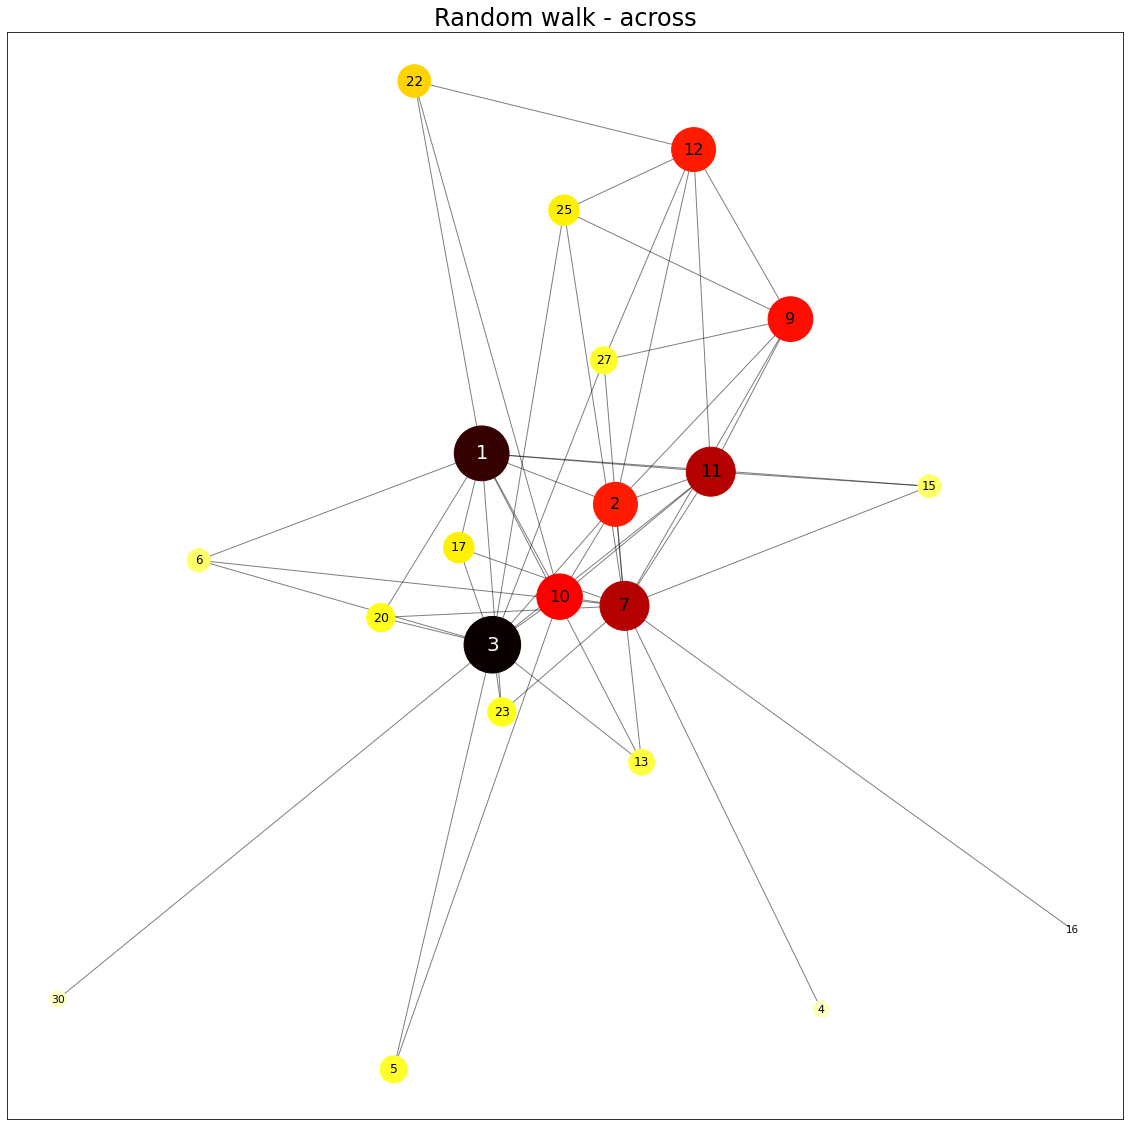

In [40]:
visited_nodes, visited_edges = random_walk(G_across)
random_walk_visu(G_across, visited_nodes, visited_edges, "across")